In [1]:
import pandas as pd
import numpy as np
import matplotlib as mp
import seaborn as sns
import re
import os

In [207]:
groups = ['Control','1_group','2_group','3_group','4_group','blank']
times = ['None','0_h','4_h','8_h','20_h','24_h','28_h','32_h','44_h','48_h']

labels_groups= [['B2','C2','D2','E2','F2','G2'],
['B3','B4','B5','B6','B7','B8','B9','B10','B11'],
['C3','C4','C5','C6','C7','C8','C9','C10','C11'],
['D3','D4','D5','D6','D7','D8','D9','D10','D11'],
['E3','E4','E5','E6','E7','E8','E9','E10','E11'],
['F3','G3']]


labels_times = [['B2','C2','D2','E2','F2','G2','F3','G3'],
['B3', 'C3', 'D3', 'E3'],
['B4', 'C4', 'D4', 'E4'],
['B5', 'C5', 'D5', 'E5'],
['B6', 'C6', 'D6', 'E6'],
['B7', 'C7', 'D7', 'E7'],
['B8', 'C8', 'D8', 'E8'],
['B9', 'C9', 'D9', 'E9'],
['B10', 'C10', 'D10', 'E10'],
['B11', 'C11', 'D11', 'E11']]


def image_name_to_label(image_path):
    image_name = os.path.basename(image_path)
    image_name_str = str(image_name)
    well_name_re = re.search(r'([B-G]\d{1,2})',image_name_str)

    return well_name_re[0]

def image_label_to_group(well_label):
    for i,group in enumerate(labels_groups):
        print(well_label)
        for y,value in enumerate(group):
            if well_label in value:
                index_g = i
                
    group_label = groups[index_g]

    return(group_label)

def image_label_to_time(well_label):
    for i,group in enumerate(labels_times):
        for y,value in enumerate(group):
            if well_label in value:
                index_t = i

    time_label = times[index_t]

    return(time_label)

                
    


In [277]:
path_nuclei = "C:/Users/Modern/Desktop/Kirill/Counted/MyExpt_Nucleus_filtered.csv"
path_focii = "C:/Users/Modern/Desktop/Kirill/Counted/MyExpt_H2AX_in_nucleus.csv"
path_image_data = "C:/Users/Modern/Desktop/Kirill/Counted/MyExpt_Image.csv"

nuclei_pd=pd.read_csv(path_nuclei)
focii_pd=pd.read_csv(path_focii)
image_data_pd=pd.read_csv(path_image_data)

labels_nuclei = nuclei_pd.head()
labels_focii = focii_pd.head()
labels_image_data = image_data_pd.head()

print(labels_nuclei)



   ImageNumber  ObjectNumber  AreaShape_Area  AreaShape_FormFactor  \
0            2             1            6870              0.778445   
1            2             2            7270              0.725829   
2            2             3            7923              0.772438   
3            3             1            5208              0.817290   
4            3             2            4510              0.798877   

   Children_Masked_H2AX_Count  Location_Center_X  Location_Center_Y  \
0                          15         283.328675         272.503639   
1                          32        1143.283494         314.853232   
2                          76        1031.996971         327.321722   
3                           6         535.430492         350.460253   
4                          15         434.543902         970.905100   

   Location_Center_Z  Number_Object_Number  Parent_Nucleus  
0                  0                     1               1  
1                  0          

In [275]:
labels = image_data_pd['URL_Dapi'].apply(image_name_to_label)

labels_df = pd.DataFrame(labels)

well_group = labels_df['URL_Dapi'].apply(image_label_to_group)
well_time = labels_df['URL_Dapi'].apply(image_label_to_time)

labels_df["Group"] = well_group
labels_df["Time"] = well_time


labels_df = labels_df.join(image_data_pd['ImageNumber'])
labels_df = labels_df.rename(columns={'URL_Dapi':'Well_Name'})

B10
B10
B10
B10
B10
B10
B11
B11
B11
B11
B11
B11
B2
B2
B2
B2
B2
B2
B3
B3
B3
B3
B3
B3
B4
B4
B4
B4
B4
B4
B5
B5
B5
B5
B5
B5
B6
B6
B6
B6
B6
B6
B7
B7
B7
B7
B7
B7
B8
B8
B8
B8
B8
B8
B9
B9
B9
B9
B9
B9
C10
C10
C10
C10
C10
C10
C11
C11
C11
C11
C11
C11
C2
C2
C2
C2
C2
C2
C3
C3
C3
C3
C3
C3
C4
C4
C4
C4
C4
C4
C5
C5
C5
C5
C5
C5
C6
C6
C6
C6
C6
C6
C7
C7
C7
C7
C7
C7
C8
C8
C8
C8
C8
C8
C9
C9
C9
C9
C9
C9
D10
D10
D10
D10
D10
D10
D11
D11
D11
D11
D11
D11
D2
D2
D2
D2
D2
D2
D3
D3
D3
D3
D3
D3
D4
D4
D4
D4
D4
D4
D5
D5
D5
D5
D5
D5
D6
D6
D6
D6
D6
D6
D7
D7
D7
D7
D7
D7
D8
D8
D8
D8
D8
D8
D9
D9
D9
D9
D9
D9
E10
E10
E10
E10
E10
E10
E11
E11
E11
E11
E11
E11
E2
E2
E2
E2
E2
E2
E3
E3
E3
E3
E3
E3
E4
E4
E4
E4
E4
E4
E5
E5
E5
E5
E5
E5
E6
E6
E6
E6
E6
E6
E7
E7
E7
E7
E7
E7
E8
E8
E8
E8
E8
E8
E9
E9
E9
E9
E9
E9
F2
F2
F2
F2
F2
F2
F3
F3
F3
F3
F3
F3
G2
G2
G2
G2
G2
G2
G3
G3
G3
G3
G3
G3
B10
B10
B10
B10
B10
B10
B11
B11
B11
B11
B11
B11
B2
B2
B2
B2
B2
B2
B3
B3
B3
B3
B3
B3
B4
B4
B4
B4
B4
B4
B5
B5
B5
B5
B5
B5
B6
B6
B6
B6
B6
B6
B7
B7
B7
B7
B7
B7
B8
B

In [278]:
nuclei_pd = nuclei_pd.merge(labels_df[['Well_Name','ImageNumber',"Group","Time"]],'left')


In [339]:
# rslt_df = nuclei_pd[(nuclei_pd['Group'] == "Control" ) & (nuclei_pd['Time'] == "None"   ) |
#                         (nuclei_pd['Group'] == '4_group' ) & (nuclei_pd['Time'] == "4_h")]

# rslt_df = nuclei_pd[(nuclei_pd['Time'] == "None") |(nuclei_pd['Time'] == "48_h")]
rslt_df = nuclei_pd[(nuclei_pd['Group'] == "1_group")]

# column_sum_1 = nuclei_pd.loc[(nuclei_pd['Group']=="Control") & (nuclei_pd['Time'] == "None"),'Children_Masked_H2AX_Count'].mean()
# column_sum_2 = nuclei_pd.loc[(nuclei_pd['Group'] == '4_group' ) & (nuclei_pd['Time'] == "4_h"),'Children_Masked_H2AX_Count'].mean()

# column_std_2 = nuclei_pd.loc[(nuclei_pd['Group'] == '4_group' ) & (nuclei_pd['Time'] == "4_h"),'Children_Masked_H2AX_Count'].std()

# print(column_sum_2)

means = nuclei_pd['Children_Masked_H2AX_Count'].groupby(nuclei_pd['Time']).mean()
print(means)

Time
0_h     38.278908
20_h    39.637950
24_h    36.677957
28_h    36.313223
32_h    39.358521
44_h    44.163955
48_h    32.703681
4_h     36.806985
8_h     35.336316
None     9.296482
Name: Children_Masked_H2AX_Count, dtype: float64


[Text(0.5, 0, 'Number per nucleus'), Text(0, 0.5, 'Relative count')]

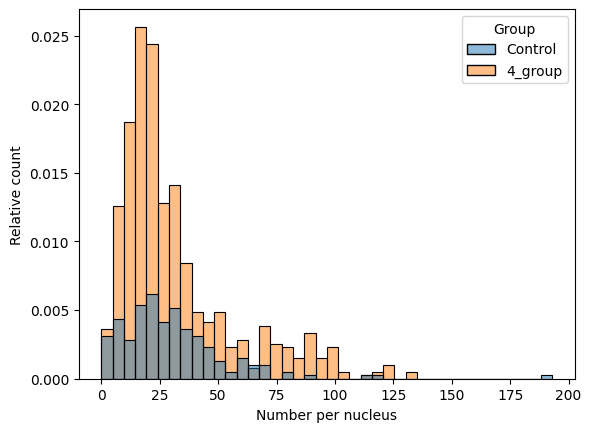

In [308]:
# stat='density' make normilized hystogramm

ax = sns.histplot(data=rslt_df, x=rslt_df['Children_Masked_H2AX_Count'],hue='Group',stat='density')
ax.set(xlabel='Number per nucleus', ylabel='Relative count')


[Text(0.5, 0, 'Foci per nucleus'), Text(0, 0.5, 'Nucleus area')]

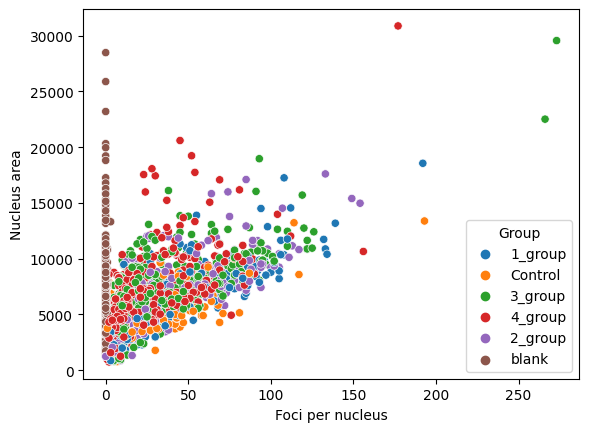

In [313]:
ax = sns.scatterplot(data=rslt_df, x = rslt_df['Children_Masked_H2AX_Count'], y = rslt_df['AreaShape_Area'],hue='Group' )
ax.set(xlabel='Foci per nucleus', ylabel='Nucleus area')

[Text(0.5, 0, 'Foci per nucleus'), Text(0, 0.5, 'Nucleus area')]

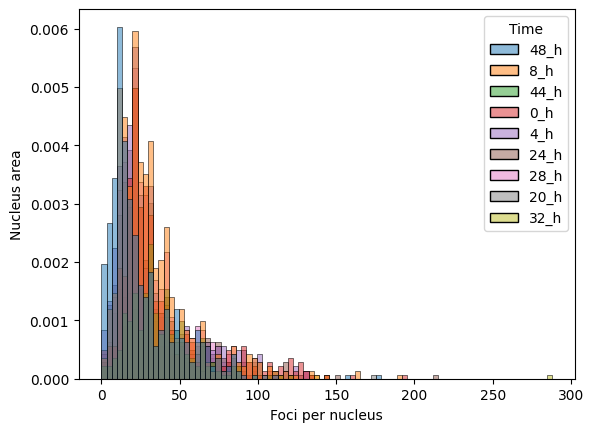

In [320]:
rslt_df = nuclei_pd[(nuclei_pd['Group'] == "4_group")]
ax = sns.histplot(data=rslt_df, x=rslt_df['Children_Masked_H2AX_Count'],hue='Time',stat='density')
ax.set(xlabel='Foci per nucleus', ylabel='Nucleus area')

In [383]:
means = nuclei_pd.groupby(['Group','Time'])['Children_Masked_H2AX_Count'].mean()
means_pd = pd.DataFrame(means)
means_pd['Time'] =pd.Categorical(means_pd['Time'], categories = times, ordered = True )
print(means_pd)

KeyError: 'Time'